# Vision por Computadora II - Trabajo final

<p style='text-align: justify;'>
    El presente trabajo tiene como objetivo aplicar los conocimientos adquirido durante el cursado de "Visión por Computadora II" de la Carrera de Especialización en Inteligencia Artificial.Para ello se plantea obtener un algoritmo capaz de localizar y clasificar distintas fallas superficiales en laminas de acero.
</p>

<p style='text-align: justify;'>
    El dataset se obtuvo de la competencia de Kaggle "Severstal Steel Defect Detection" (https://www.kaggle.com/c/severstal-steel-defect-detection/overview).
</p>

A continuación se realiza un analisis exploratorio inicial del dataset.


## Librerias utilizadas:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline

from os import listdir

import os
import csv
import json
import pickle as pkl
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization, Dense, Add, ReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
import random

from keras.utils.vis_utils import plot_model


# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("Pandas",pd.__version__),
    ("Seaborn",sns.__version__),
    ("Open CV",cv2.__version__)
]))

n_w = 1600
n_h = 256

Numpy:1.19.2
Pandas:1.3.1
Seaborn:0.11.1
Open CV:4.0.1



## Check TF GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

## 1. Análisis exploratorio inicial

#### Path del dataset
<p style='text-align: justify;'>
    El dataset con el que trabajaremos esta compuesto una carpeta "train_images" que contiene las imagenes para el entrenamiento de nuestro algoritmo y un archivo "train.csv" que enlista las imagenes de la carpeta mencionada que contienen alguna falla. Este archivo detalla el ID de la falla y describe los pixeles donde se encuentra dicha falla.
    </p>

In [4]:
csv_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train.csv"
train_path = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_images/"

### train_images

#### Indice de imagenes

<p style='text-align: justify;'>
    En la variable "archivos" generamos un listado de nombres de todas las imagenes.
    </p>

In [5]:
archivos = listdir(train_path)
print(f"Cantidad de imagenes: {len(archivos)}")

Cantidad de imagenes: 12568


### train.csv

#### Lectura del archivo

In [6]:
train_csv = pd.read_csv(csv_path)

#### Visualizacion de las primeras 5 filas del archivo

<p style='text-align: justify;'>
    A continuación podemos ver el archivos train.csv contiene una tabla de tres columnas. La primera de ellas contiene el ID de la imagen, la segunda el ID de la clase de falla y por ultimo se encuentran codificados los pixeles que forman parte de dicha falla.
    </p>

In [7]:
train_csv.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

#### Analisis de las etiquetas

<p style='text-align: justify;'>
    Como mencionamos anteriormente nuestro dataset contiene 3 columnas, a través del comando DataFrame.info() de la libreria Pandas, vemos que tenemos 7095 etiquetas. Esto quiere decir que tenemos 7095 fallas etiquetadas en las 12568 imagenes que tenemos. Realizando un análisis más profundo podemos ver las fallas etiquetadas se encuentran repartidas en 6666 imagenes de nuestro dataset.
    </p>

In [8]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [9]:
print(f"Imagenes con fallas: {len(np.unique(train_csv.ImageId))}")
print(f"Clases de fallas: {len(np.unique(train_csv.ClassId))}")
print(f"Fallas etiquetadas: {len(train_csv.ImageId)}")

Imagenes con fallas: 6666
Clases de fallas: 4
Fallas etiquetadas: 7095


<p style='text-align: justify;'>
    Se crea el Data Frame "fallas" que contiene dos columans, una de ellas contendra el ID de las imagenes y la otra la cantidad de fallas que se detectaron en dicha imagen, con el objetivo de obtener el detalle de cuantas images contiene distintas cantidades de fallas.
    </p>

In [10]:
fallas = pd.DataFrame(columns = ['ImageId', 'Cantidad de Fallas'])
i=0
for arch in archivos:
    fallas.loc[i] = [arch] + [len(list(train_csv[train_csv.eq(arch).any(1)].ImageId))]
    i += 1

fallas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12568 entries, 0 to 12567
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ImageId             12568 non-null  object
 1   Cantidad de Fallas  12568 non-null  object
dtypes: object(2)
memory usage: 294.6+ KB


In [11]:
# Se buscan aquellas imagenes que poseen 3 fallas
fallas[fallas.eq(3).any(1)].ImageId

10803    db4867ee8.jpg
11776    ef24da2ba.jpg
Name: ImageId, dtype: object

In [12]:
fallas.head()

ImageId Cantidad de Fallas
0  0002cc93b.jpg                  1
1  00031f466.jpg                  0
2  000418bfc.jpg                  0
3  000789191.jpg                  0
4  0007a71bf.jpg                  1

Cantidades por Fallas:
Imagenes con 0 fallas: 5902 -> 46.96053469127944%
Imagenes con 1 fallas: 6239 -> 49.64194780394653%
Imagenes con 2 fallas: 425 -> 3.3816040738383197%
Imagenes con 3 fallas: 2 -> 0.015913430935709738%


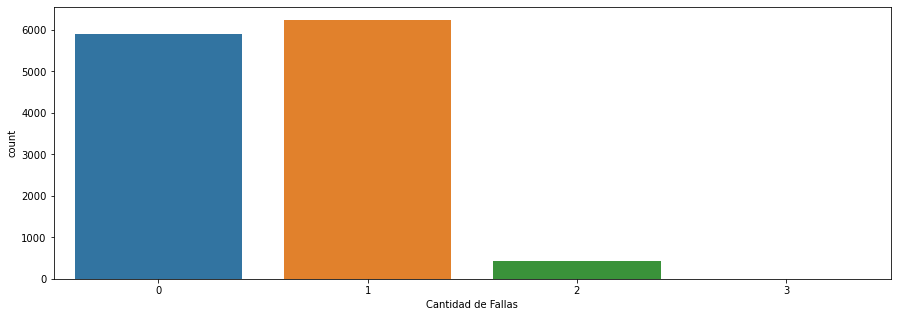

In [13]:
fig,axes = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='Cantidad de Fallas', data=fallas)

print("Cantidades por Fallas:")
for i in range(fallas['Cantidad de Fallas'].nunique()):
    print(f"Imagenes con {i} fallas: {np.sum(fallas['Cantidad de Fallas'] == i)} -> {np.sum(fallas['Cantidad de Fallas'] == i)*100/fallas['Cantidad de Fallas'].count()}%")

<p style='text-align: justify;'>
    Finalmente, se analiza el balance de los ID de fallas que tenemos en el dataset. Vemos un claro desbalance  debido a una gran cantidad de fallas de la falla de tipo 3 en comparación con el resto de los tipos.
    </p>

In [14]:
print(f"Falla tipo 1: {np.sum(train_csv.ClassId==1)}")
print(f"Falla tipo 2: {np.sum(train_csv.ClassId==2)}")
print(f"Falla tipo 3: {np.sum(train_csv.ClassId==3)}")
print(f"Falla tipo 4: {np.sum(train_csv.ClassId==4)}")

Falla tipo 1: 897
Falla tipo 2: 247
Falla tipo 3: 5150
Falla tipo 4: 801


<AxesSubplot:xlabel='ClassId', ylabel='count'>

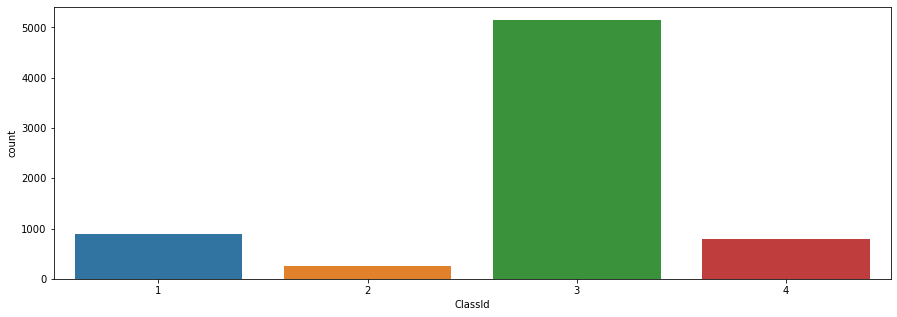

In [15]:
fig,axes = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='ClassId', data=train_csv)

### Conclusiones

<p style='text-align: justify;'>
    En resumen, se tiene un dataset con 12568 imagenes, donde el 53% de ellas (6666 imagenes) poseen una o más fallas. Estas fallas se pueden clasificar en 4 según el ID de su etiqueta.
    
Por otro lado, en estas 6666 imagenes se encuentran etiquetadas 7095 fallas con un claro desbalance dado que el 73% de las fallas son de tipo 3.
    
En el desarrollo de nuestro algoritmo debemos tener en cuenta este desbalance entre los tipos de fallas, que hay imagenes con
    </p>

#### Visualización de imagenes

<p style='text-align: justify;'>
    Se muestran las primeras 5 imagenes del archivo train.csv:
    </p>

ID de la imagen: 0002cc93b.jpg
Tamaño de la imagen: (256, 1600, 3)


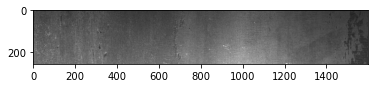

ID de la imagen: 0007a71bf.jpg
Tamaño de la imagen: (256, 1600, 3)


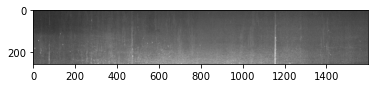

ID de la imagen: 000a4bcdd.jpg
Tamaño de la imagen: (256, 1600, 3)


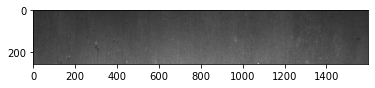

ID de la imagen: 000f6bf48.jpg
Tamaño de la imagen: (256, 1600, 3)


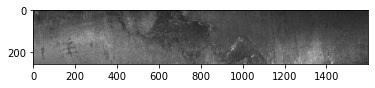

ID de la imagen: 0014fce06.jpg
Tamaño de la imagen: (256, 1600, 3)


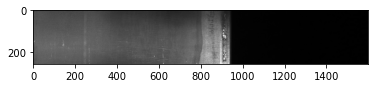

ID de la imagen: 0025bde0c.jpg
Tamaño de la imagen: (256, 1600, 3)


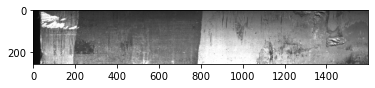

In [16]:
i = 0
for imgid in train_csv.ImageId:
    print(f"ID de la imagen: {imgid}")
    img = cv2.imread(train_path + '/' + imgid)
    imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    print(f"Tamaño de la imagen: {img.shape}")
    plt.imshow(imgRGB)
    plt.show()
    i+=1
    if i > 5:
        break

## Ingenieria de Features
<p style='text-align: justify;'>
     Para el entrenamiento del algoritmo se comenzó con la creacion de un dataset que contuviera todas las muestras con fallas y un cierto numero de muestras sin defectos.
</p>

### Creación del dataset
<p style='text-align: justify;'>
     En las variables 'defective_img' y 'nondefective_img' guardamos los nombres de los archivos de imagenes con fallas etiquetadas y sin fallas respectivamente.
</p>

In [17]:
defective_csv = pd.read_csv(csv_path)
defective_img = [value for value in listdir(train_path) if value in list(defective_csv['ImageId'])]
nondefective_img = [value for value in listdir(train_path) if value not in list(defective_csv['ImageId'])]

print(f"Muestras con fallas etiquetadas: {len(defective_img)}")
print(f"Muestras sin fallas etiquetadas: {len(nondefective_img)}")

Muestras con fallas etiquetadas: 6666
Muestras sin fallas etiquetadas: 5902


<p style='text-align: justify;'>
    Con estas dos variables creamos el dataset con todas las imagenes con fallas etiquetadas y adicionamos 666 de imagenes sin falla.
</p>

In [18]:
idx_aux= np.random.permutation(len(nondefective_img))[0: int(len(defective_img)*0.1)-1]
dataset_img = defective_img + [nondefective_img[value] for value in idx_aux]

print(f'Cantidad de imagenes en nuestro dataset: {len(dataset_img)}')

Cantidad de imagenes en nuestro dataset: 7331


### Separación en Train, Test y Validation

In [19]:
x_train, x_test = model_selection.train_test_split( dataset_img, test_size=0.1, random_state=5)
x_train, x_valid = model_selection.train_test_split( x_train, test_size=0.1, random_state=5)

### Decodificación de región de falla y creación de máscara

<p style='text-align: justify;'>
    La siguiente función 'decode_pixels' recibe una lista que contiene la codificación de los pixeles donde se encuentra la falla en determinada imagen y devuelve el listado de pixeles que deben ser incluido en la máscara para identificar la posicion de la falla. Esta información es extraida del archivo train.csv de la columna 'EncodedPixels'. La información en custión esta codificada de modo que consiste en una serie de números separados por espacio, y su significado se va alternando en pixel y cantidad de pixel sucesivos que formarán parte de la máscara. Por ejemplo si la función resibe "1 3 10 5", implica que que los pixeles 1, 2, 3, 10, 11, 12, 13, 14 deben estar incluidos en la máscara. 
</p>

In [20]:
def decode_pixels(pixels_str):
    """
    This function receives a list which contains the pixels as a space-separated code.
    For example, '1 3 10 5' implies pixels 1, 2, 3, 10, 11, 12, 13, 14 are to be included in the mask
    """
    
    pixels_encoded_list = pixels_str.split(' ')
    pixels_list = []
    for i in range(0, len(pixels_encoded_list), 2):
        # Add to the pixels list all the pixels encoded by the 2 digits
        pixels_list += range(
            int(pixels_encoded_list[i]) - 1,
            int(pixels_encoded_list[i]) + int(pixels_encoded_list[i + 1]) - 1,
        )
        
    # Return the decoded list    
    return pixels_list

<p style='text-align: justify;'>
    La función 'make_mask' que se muestra a continuación se diseño para obtener las máscaras de las imágenes que se utilizarán en el entrenamiento de los modelos. Esta función recibe el id de una imagen y la variable n_class.
    
Si n_class=1 entonces se crea una máscara que contiene todas las fallas de la imagen sin importar que sean de distinto tipo.
    
Si n_class=4 entonces se genera una máscara para cada tipo de falla devolviendo asi un arreglo de 4 máscaras, una por tipo de falla.
</p>

In [21]:
def make_mask(ImageId, n_class=1):
    """
    This function create the mask(s) to train the CNN models. It receives the ImageId and the number of classes to analyse.
    
    If the n_class is 1, it creates a mask for the image where all the failures in the image w
    
    """
    y_out=defective_csv[defective_csv['ImageId'].eq(ImageId)]
    
    image_pixels = np.zeros((n_h, n_w,n_class), dtype=np.float32)

    for index, row in y_out.iterrows():

        # Generate the mask of the error type
        mask = np.zeros((n_h * n_w, 1), dtype=np.float32)
        mask[decode_pixels(row['EncodedPixels'])] = 1
        mask = mask.reshape(n_w, n_h)
        mask = mask.T
    
        # Update channel of the given error
        if n_class == 1:
            image_pixels [:,:,0] = np.logical_or(image_pixels [:,:,0],mask)
        else:
            image_pixels [:,:,int(row['ClassId'])-1] = np.logical_or(image_pixels [:,:,int(row['ClassId'])-1],mask)
            
    return image_pixels

### Funciones de Data Augmentation

<p style='text-align: justify;'>
    Para la aplicación de data augmentation se crearon tres funciones flip, rotate y shift que afectan a las imagenes como expresan su nombre. La función flip voltea la imagen y su máscara ya se horizontal y/o verticalmente segun sean sus argumentos. La función rotate rota la imagen y su máscara un determinado ángulo y tiene la posibilidad de reescalarla. Por último, la funcion shift la desplaza de manera horizontal y/o verticalmente según sus argumentos.
</p>

In [22]:
def flip(image, mask , vflip=False, hflip=False):
    '''
    Flip the image
    :param image: image to be processed
    :param vflip: whether to flip the image vertically
    :param hflip: whether to flip the image horizontally
    '''
    if hflip or vflip:
        if hflip and vflip:
            c = -1
        else:
            c = 0 if vflip else 1
        image = cv2.flip(image, flipCode=c)
        mask = cv2.flip(mask, flipCode=c)
    return image, mask

def rotate(image, mask, angle=90, scale=1.0):
    '''
    Rotate the image
    :param image: image to be processed
    :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
    :param scale: Isotropic scale factor.
    '''
    w = image.shape[1]
    h = image.shape[0]
    #rotate matrix
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
    #rotate
    image = cv2.warpAffine(image,M,(w,h))
    mask = cv2.warpAffine(mask,M,(w,h))
    return image, mask
    
def shift(image, mask, px, py):
    w = image.shape[1]
    h = image.shape[0]
    
    img = np.zeros((h,w))
    m = np.zeros((h,w))   
    
    if (py > 0) and (px > 0):
        img[py:, px:] = image[:-py, :-px]
        m[py:, px:] = mask[:-py, :-px]
    elif (py < 0) and (px < 0):
        img[:py, :px] = image[-py:, -px:]
        m[:py, :px] = mask[-py:, -px:]
    elif (py > 0) and (px < 0):
        img[py:, :px] = image[:-py, -px:]
        m[py:, :px] = mask[:-py, -px:]
    elif (py < 0) and (px > 0):
        img[:py, px:] = image[-py:, :-px]
        m[:py, px:] = mask[-py:, :-px]
    
    return img, m

## Data generator

In [23]:
def data_generator(ids, batch_size, n_class = 4):
    Xs = []; ys = []
    
    while True:
        i = 0
        random.shuffle(ids)
        aug_shift = np.random.randint(2, size=len(ids))
        aug_rot = np.random.randint(2, size=len(ids))
        aug_flip = np.random.randint(2, size=len(ids))
        for id in ids:
            img = cv2.imread(train_path + id)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            img = img / 255.
            
            mask = make_mask(id,n_class=4)
            
            img=cv2.resize(img, (int(img.shape[1]/2),int(img.shape[0]/2)))
            mask=cv2.resize(mask, (int(mask.shape[1]/2),int(mask.shape[0]/2)))
            
            #if aug_shift[i] == 1:
            #    img, mask = shift(img, mask,
            #                      px=np.random.randint(low = -int(img.shape[1]/10),high = int(img.shape[1]/10)),
            #                      py=np.random.randint(low = -int(img.shape[0]/10),high = int(img.shape[0]/10))
            #                     )
            #if aug_rot[i] == 1:
            #    img, mask = rotate(img, mask, angle=np.random.randint(-10,10), scale=1.0 + (random.randint(0,20)/10) )
            #if aug_flip[i] == 1:
            #    img, mask = flip(img, mask, vflip=True, hflip=False)
            #mask = (mask > 0.2) * 1.0
            #
            #i+=1
            
            Xs.append(img); ys.append(mask)
            if len(Xs) == batch_size:
                X = np.array(Xs); y = np.array(ys)
                Xs = []; ys = []
                yield (X, y)

## Metricas Utiles

In [24]:
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice

def dice_coef_nd(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return 2.*intersection, (np.sum(y_true_f)+np.sum(y_pred_f))

def dice_loss(y_true,y_pred):
    return (1 - dice_coef(y_true,y_pred))

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (1 - ((true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)))

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true)+K.sum(y_pred)-intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou.numpy()

## xxx. Creación de dataset balanceado en tipos de fallas

<p style='text-align: justify;'>
    En el entrenamiento del algoritmo nos encontramos con grandes errores al reconocer fallas del tipo 1, 2 y 4, lo cual lo adjudicamos al desbalance entre los distintos tipos de falla. Dado la gran cantidad de muestras con fallas de tipo 3 los pesos aprendidos se vieron sesgados por dicho desbalance.
    
Para subsanar esta problematica se decidió crear un dataset más balanceado.
</p>

In [25]:
# Path dataset reducido
csv_reducido = r"C:\Users\Agustin\Documents\RepositorioCEIA_Git\VpC2_Datasets\severstal-steel-defect-detection/train_reducido.csv"

<p style='text-align: justify;'>
    Como ya hemos mencionado el dataset cuenta con 897 etiquetas de la falla tipo 1, 247 etiquetas de la falla tipo 2, 5150 etiquetas de la falla tipo 3 y finalmente 801 etiquetas de falla de tipo 4. Nuestro objetivo aqui será crear a partir de este set de entrenamiento uno más pequeño con un numero más balanceado, para ello quitaremos muestras del tipo 3. Como contrapartida obtendremos un set más pequeño.
</p>

<p style='text-align: justify;'>
    Creamos una copia del dataset original quitando todas aquellas muestras que sean de falla tipo 3.
</p>

In [26]:
train_reducido = train_csv[train_csv['ClassId']!=3].copy()
train_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 7086
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        1945 non-null   object
 1   ClassId        1945 non-null   int64 
 2   EncodedPixels  1945 non-null   object
dtypes: int64(1), object(2)
memory usage: 60.8+ KB


<p style='text-align: justify;'>
    Creamos una copia del dataset original solo con las fallas tipo 3.
</p>

In [27]:
type_3 = train_csv[train_csv['ClassId']==3].copy()
type_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5150 entries, 1 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        5150 non-null   object
 1   ClassId        5150 non-null   int64 
 2   EncodedPixels  5150 non-null   object
dtypes: int64(1), object(2)
memory usage: 160.9+ KB


<p style='text-align: justify;'>
    A continuación concatenamos al dataset 'train_reducido' 900 muestras con fallas de tipo 3:
</p>

In [28]:
train_reducido = pd.concat([train_reducido, type_3[:900]])
train_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2845 entries, 0 to 1265
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        2845 non-null   object
 1   ClassId        2845 non-null   int64 
 2   EncodedPixels  2845 non-null   object
dtypes: int64(1), object(2)
memory usage: 88.9+ KB


<p style='text-align: justify;'>
    Finalmente guardamos el dataset reducido en formato .csv
</p>

In [29]:
train_reducido.to_csv(csv_reducido, index=False)

# Modelos

## Modelo 1: U-Net con una salida
<p style='text-align: justify;'>
    Dado que el problema es de segmentación, nos pareció que una arquitectura que podría tener buenos resultados es la U-Net. Es por eso que el primer modelo que entrenamos fue de ese tipo, con una salida sigmóidea, de modo que clasificara falla contra fondo.

Clasificar de esta manera nos daría una idea de si la arquitectura sirve, y al mismo tiempo comenzaríamos con un problema de dos clases con un buen balance. Si el modelo fallara en este caso, ya sabríamos que no tendría sentido usarlo para el problema de classificar los distintos tipos de falla.
    </p>

In [30]:
def build_unet(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Mitad
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_unet = Input((1600, 256, 3))
output_unet = build_unet(input_unet, 16)


In [31]:
model_unet = Model(input_unet, output_unet)

In [32]:
model_unet.compile(loss="SparseCategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])
model_unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600, 256, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1600, 256, 16 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1600, 256, 16 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 800, 128, 16) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

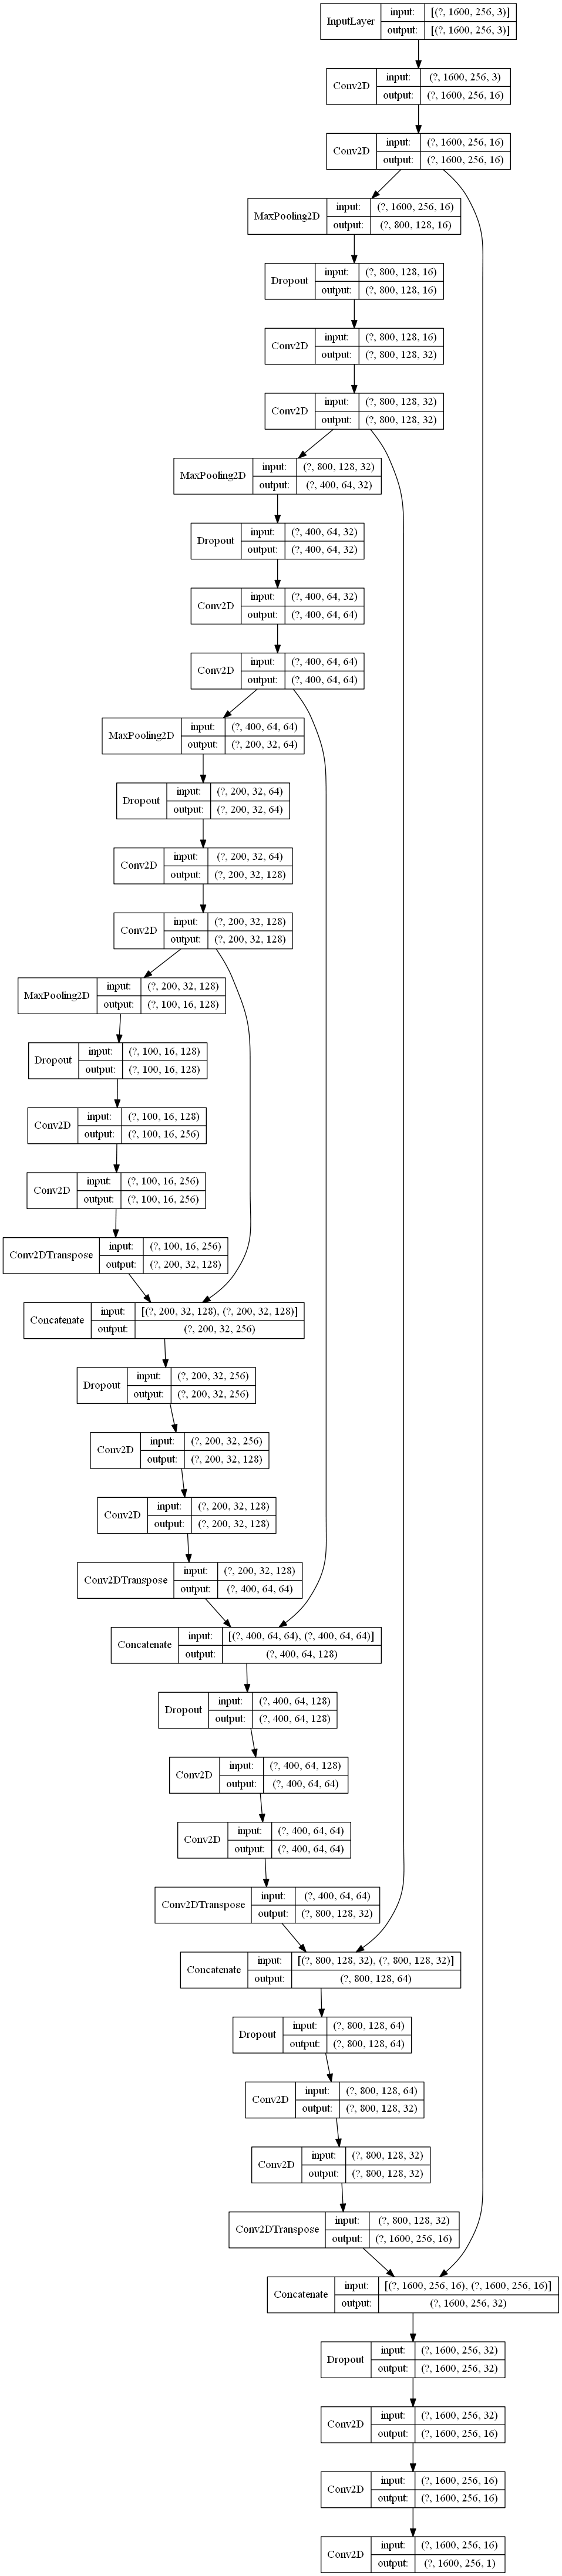

In [33]:
plot_model(model_unet, show_shapes=True, show_layer_names=False)

## Model 2: ResUnet - Inception

In [34]:
def inception_block(prevlayer, a, b):
    
    conva = Conv2D(a, (1, 1), activation='relu', padding='same')(prevlayer)
    conva = Conv2D(b, (3, 3), activation=None, padding='same')(conva)
    conva = BatchNormalization()(conva)
    conva = ReLU()(conva)
    
    convb = Conv2D(a, (1, 1), activation='relu', padding='same')(prevlayer)
    convb = Conv2D(b, (5, 5), activation=None, padding='same')(convb)
    convb = BatchNormalization()(convb)
    convb = ReLU()(convb)

    convc = Conv2D(b, (1, 1), activation=None, padding='same')(prevlayer)
    convc = BatchNormalization()(convc)
    convc = ReLU()(convc)
        
    convd = MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding= 'same')(prevlayer)
    convd = Conv2D(b, (1, 1), activation=None, padding='same')(convd)
    convd = BatchNormalization()(convd)
    convd = ReLU()(convd)
        
    up = concatenate([conva, convb, convc, convd])
    return up

In [35]:
def residual_block (input_layer, neurons):
    
    conv1 = Conv2D(neurons , (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(neurons, (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)
    conv1 = Conv2D(neurons, (5, 5), activation=None, padding="same",kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1_skip = Conv2D(neurons, 1, 1, activation=None, padding="same",kernel_initializer='he_normal')(input_layer)
    conv1_skip = BatchNormalization()(conv1_skip)
    
    added1 = Add()([conv1_skip, conv1])
    relu1 = ReLU()(added1)
    
    return relu1

In [36]:
def build_resunet(input_layer, start_neurons):
    
    conv1 = residual_block(input_layer,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    conv2 = residual_block(pool1,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)

    conv3 = residual_block(pool2,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)

    conv4 = residual_block(pool3,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)

    # Mitad
    convm = inception_block (pool4, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)
    convm = inception_block (convm, start_neurons * 4, start_neurons * 4)

    deconv4 = Conv2DTranspose(start_neurons * 8, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(0.5)(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)

    deconv3 = Conv2DTranspose(start_neurons * 4, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    #uconv3 = Dropout(0.5)(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)

    deconv2 = Conv2DTranspose(start_neurons * 2, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    #uconv2 = Dropout(0.5)(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (5, 5), strides=(2, 2), padding="same",kernel_initializer='he_normal')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    #uconv1 = Dropout(0.5)(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    return output_layer

input_resunet = Input((128, 800, 1))
output_resunet = build_resunet(input_resunet, 8)

model_resunet = Model(input_resunet, output_resunet)

In [37]:
model_resunet.load_weights('./weights/resUnetInceptionV5/resUnetInceptionV5')

In [44]:
plot_model(model_resunet, show_shapes=True, show_layer_names=False)

## Model 3: ResUnet - Inception with 4 sigmoid to detect presence or not of each class independently

In [38]:
def build_resunet_multiclass(input_layer, start_neurons):
    
    uconv1 = residual_block(input_layer,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    output_layer1 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv1)
    
    uconv2 = residual_block(input_layer,start_neurons * 1)
    uconv2 = residual_block(uconv2,start_neurons * 1)
    output_layer2 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv2)
    
    uconv3 = residual_block(input_layer,start_neurons * 1)
    uconv3 = residual_block(uconv3,start_neurons * 1)
    output_layer3 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv3)
    
    uconv4 = residual_block(input_layer,start_neurons * 1)
    uconv4 = residual_block(uconv4,start_neurons * 1)
    output_layer4 = Conv2D(1, (1,1), padding="same", activation="sigmoid",kernel_initializer='he_normal')(uconv4)
    
    uconvf = concatenate([output_layer1, output_layer2, output_layer3, output_layer4])
    
    return uconvf

output_resunet_multiclass = build_resunet_multiclass(model_resunet.layers[-4].output,4)

model_resunet_multiclass = Model(model_resunet.layers[0].input, output_resunet_multiclass)

In [39]:
model_resunet_multiclass.load_weights('./weights/resUnetInception4Sigmoid_vFinal/resUnetInception4Sigmoid_vFinal')

In [45]:
plot_model(model_resunet_multiclass, show_shapes=True, show_layer_names=False)

In [40]:
optimizer = Adam()
#model_resunet_multiclass.compile(loss=tversky, optimizer=optimizer, metrics=[dice_coef])
#model_resunet_multiclass.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[dice_coef])
model_resunet_multiclass.compile(optimizer, dice_loss, metrics=[dice_coef])

In [41]:
model_resunet_multiclass.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 800, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 800, 8)  208         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 800, 8)  32          conv2d_19[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 800, 8)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

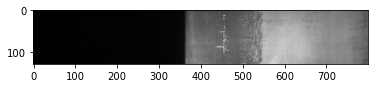

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


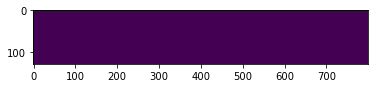

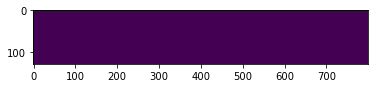

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


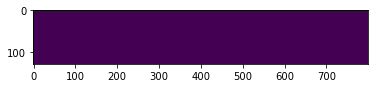

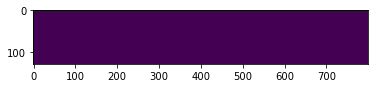

Falla tipo: 3 - IOU: 0.7394582629203796 - DICE: 0.8501608371734619


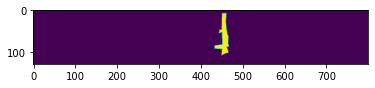

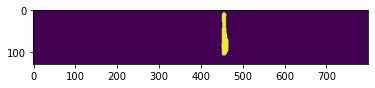

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


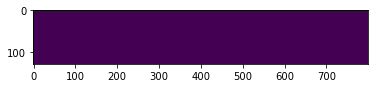

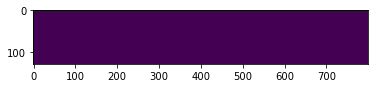

Mean IOU: 0.9348645657300949
Mean DICE: 0.9625402092933655
Keras-IOU: 0.8618671894073486


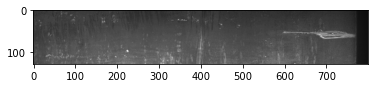

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


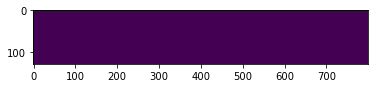

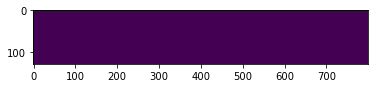

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


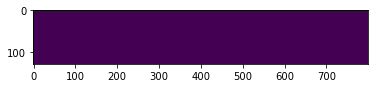

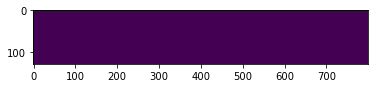

Falla tipo: 3 - IOU: 0.40093740820884705 - DICE: 0.5723535418510437


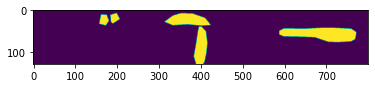

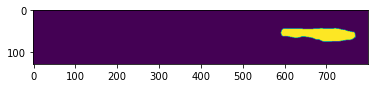

Falla tipo: 4 - IOU: 0.004328147508203983 - DICE: 0.004328147508203983


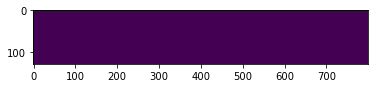

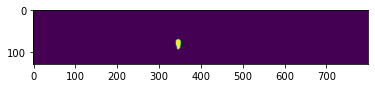

Mean IOU: 0.6013163889292628
Mean DICE: 0.6441704630851746
Keras-IOU: 0.5087146162986755


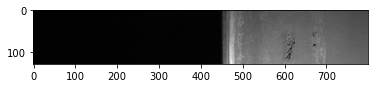

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


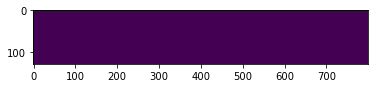

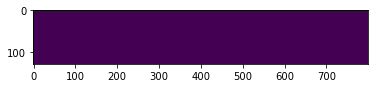

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


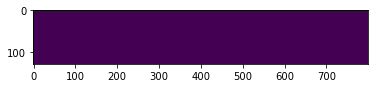

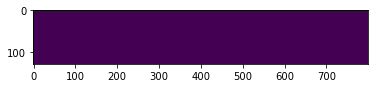

Falla tipo: 3 - IOU: 0.4122196435928345 - DICE: 0.5835939645767212


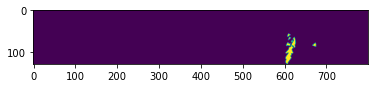

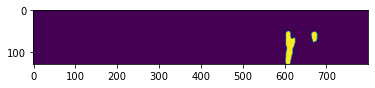

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


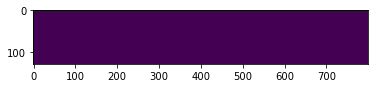

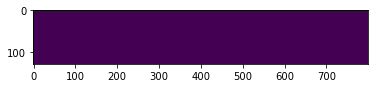

Mean IOU: 0.8530549108982086
Mean DICE: 0.8958984613418579
Keras-IOU: 0.6969494223594666


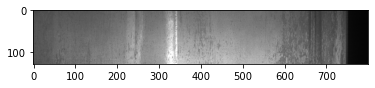

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


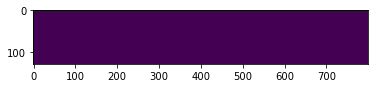

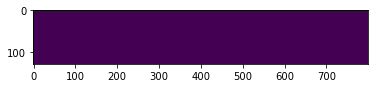

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


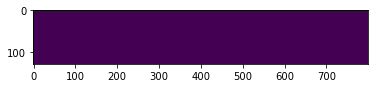

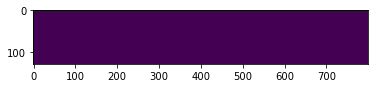

Falla tipo: 3 - IOU: 0.2780901789665222 - DICE: 0.43492966890335083


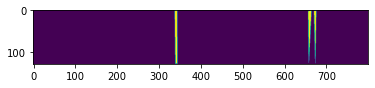

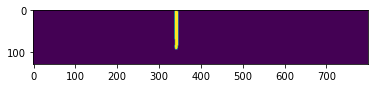

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


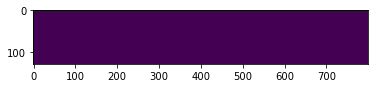

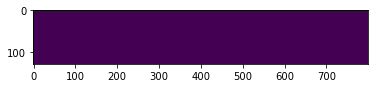

Mean IOU: 0.8195225447416306
Mean DICE: 0.8587324023246765
Keras-IOU: 0.6202767491340637


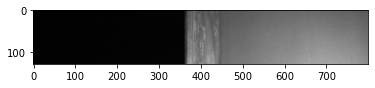

Falla tipo: 1 - IOU: 0.004571428522467613 - DICE: 0.004571428522467613


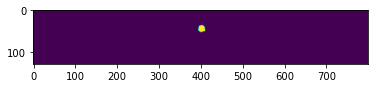

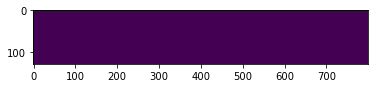

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


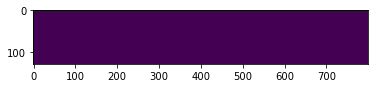

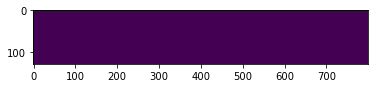

Falla tipo: 3 - IOU: 1.0 - DICE: 1.0


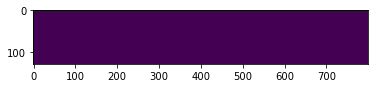

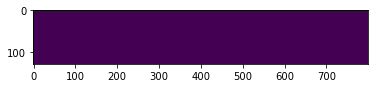

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


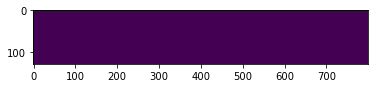

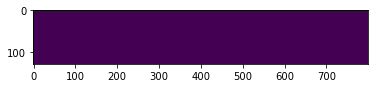

Mean IOU: 0.7511428571306169
Mean DICE: 0.7511428594589233
Keras-IOU: 0.4997534155845642


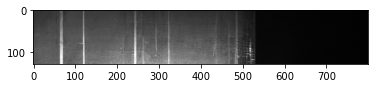

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


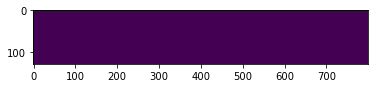

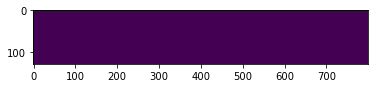

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


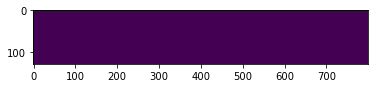

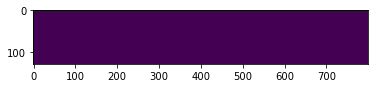

Falla tipo: 3 - IOU: 0.6819184422492981 - DICE: 0.8108705282211304


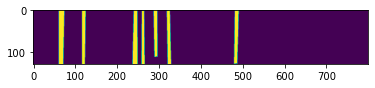

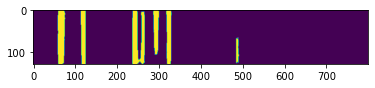

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


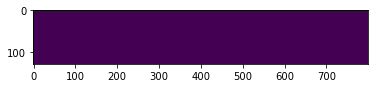

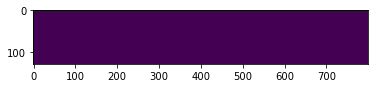

Mean IOU: 0.9204796105623245
Mean DICE: 0.952717661857605
Keras-IOU: 0.8011153936386108


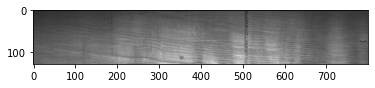

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


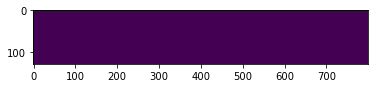

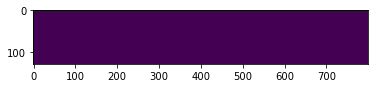

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


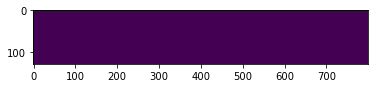

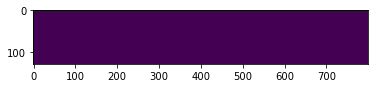

Falla tipo: 3 - IOU: 0.5966008901596069 - DICE: 0.7472801208496094


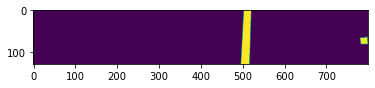

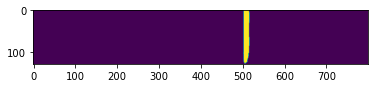

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


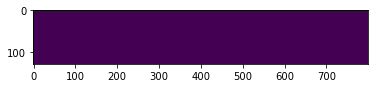

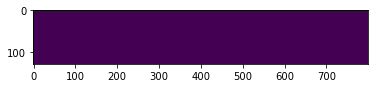

Mean IOU: 0.8991502225399017
Mean DICE: 0.9368200302124023
Keras-IOU: 0.7636324167251587


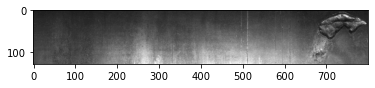

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


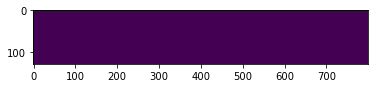

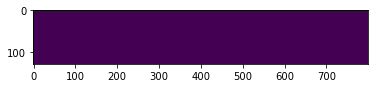

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


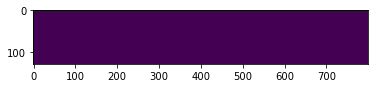

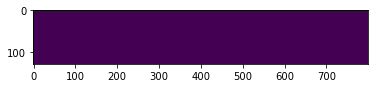

Falla tipo: 3 - IOU: 0.0002036970981862396 - DICE: 0.0002036970981862396


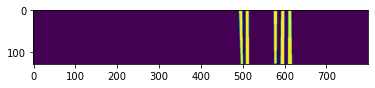

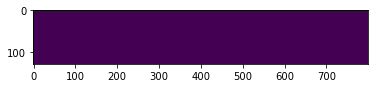

Falla tipo: 4 - IOU: 0.6993321776390076 - DICE: 0.8230500817298889


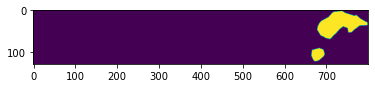

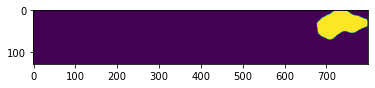

Mean IOU: 0.6748839686842985
Mean DICE: 0.7058134078979492
Keras-IOU: 0.6892620921134949


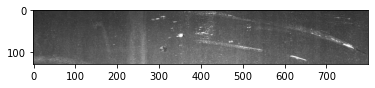

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


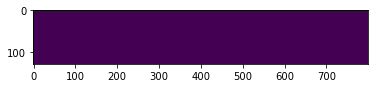

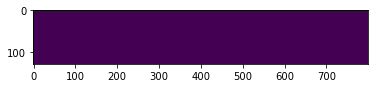

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


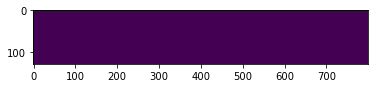

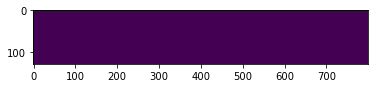

Falla tipo: 3 - IOU: 0.18306492269039154 - DICE: 0.3094607889652252


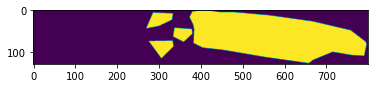

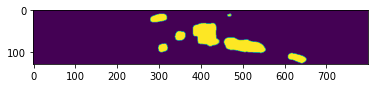

Falla tipo: 4 - IOU: 0.0007821816834621131 - DICE: 0.0007821816834621131


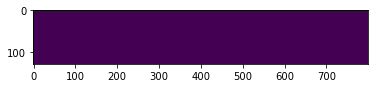

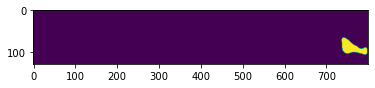

Mean IOU: 0.5459617760934634
Mean DICE: 0.5775607824325562
Keras-IOU: 0.4598769247531891


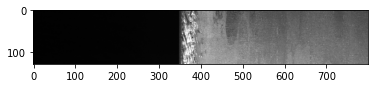

Falla tipo: 1 - IOU: 1.0 - DICE: 1.0


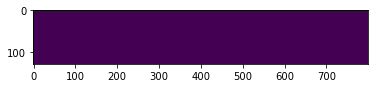

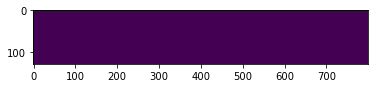

Falla tipo: 2 - IOU: 1.0 - DICE: 1.0


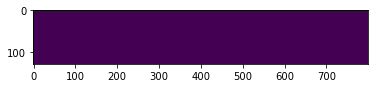

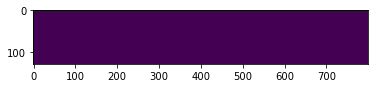

Falla tipo: 3 - IOU: 0.0001742615713737905 - DICE: 0.0001742615713737905


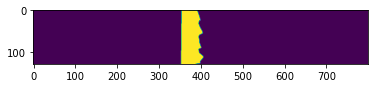

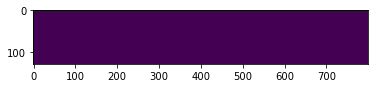

Falla tipo: 4 - IOU: 1.0 - DICE: 1.0


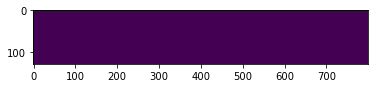

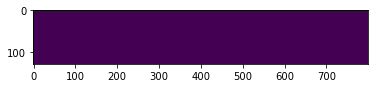

Mean IOU: 0.7500435653928434
Mean DICE: 0.7500435709953308
Keras-IOU: 0.49311402440071106

Mean IOU Total: 0.7750420410702645
Mean DICE Total: 0.6394562244415283
Keras-IOU Total: 0.8035440444946289


In [42]:
test_generator = data_generator(x_test,batch_size=1, n_class = 4)

iou_total = 0
iou_keras_total = 0
dice_total = 0

for i in range(10):
    data_test = next(test_generator)
    prediction = model_resunet_multiclass.predict(data_test[0])
    plt.imshow(data_test[0][0],cmap='gray', vmin=0, vmax=1)
    plt.show()
    
    iou = 0
    dice_1 = 0

    y_pred_keras = []
    y_true_keras = []
    for j in range(data_test[1][0].shape[2]):
        y_true = data_test[1][0][:,:,j]
        y_pred = prediction[0][:,:,j]
        
        y_pred = (y_pred[:, :] > 0.5) * y_pred
        print(f"Falla tipo: {j+1} - "
              f"IOU: {iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)} - "
              f"DICE: {dice_coef(y_true, y_pred)}")
        iou += iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
        dice_1 += dice_coef(y_true, y_pred)
        plt.imshow(y_true)
        plt.show()
        plt.imshow(y_pred)
        plt.show()
        
        y_pred_keras.append(y_pred)
        y_true_keras.append(y_true)
        
    print(f"Mean IOU: {iou/4}")
    print(f"Mean DICE: {dice_1/4}")
    
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(y_true_keras, y_pred_keras).numpy()
    #m.update_state([data_test[1][0][:,:,0], data_test[1][0][:,:,1], data_test[1][0][:,:,2], data_test[1][0][:,:,3]],
    #                [prediction[0][:,:,0], prediction[0][:,:,1], prediction[0][:,:,2], prediction[0][:,:,3]]).numpy()
    print(f"Keras-IOU: {m.result().numpy()}")
    
    iou_total += iou/4
    iou_keras_total += dice_1/4
    dice_total += m.result().numpy()
    
print()
print(f"Mean IOU Total: {iou_total/10}")
print(f"Mean DICE Total: {dice_total/10}")
print(f"Keras-IOU Total: {iou_keras_total/10}")

### Testeo de modelo
<p style='text-align: justify;'>
    
</p>


In [43]:
test_generator = data_generator(x_test,batch_size=1)

iou_total = 0
iou_keras_total = 0
dice_total = 0

for i in range(len(x_test)):
    data_test = next(test_generator)
    prediction = model_resunet_multiclass.predict(data_test[0])
    
    iou = 0
    dice_1 = 0

    y_pred_keras = []
    y_true_keras = []
    for j in range(data_test[1][0].shape[2]):
        y_true = data_test[1][0][:,:,j]
        y_pred = prediction[0][:,:,j]
        y_pred = (y_pred[:, :] > 0.5) * y_pred
        
        #print(f"Falla tipo: {j+1} - IOU: {iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)} - DICE: {dice_coef(y_true, y_pred)}")
        #print(f"Interseccion: {K.sum(K.abs(y_true * y_pred))}")
        iou += iou_coef(K.flatten(y_true), K.flatten(y_pred), smooth=1)
        dice_1 += dice_coef(y_true, y_pred).numpy()

        y_pred_keras.append(y_pred)
        y_true_keras.append(y_true)
    
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(y_true_keras, y_pred_keras).numpy()
    
    #print(f"Mean IOU: {iou/4}")
    #print(f"Mean DICE: {dice_1/4}")
    #print(f"Keras-IOU: {m.result().numpy()}")
    #print()
    iou_total += iou/4
    iou_keras_total += dice_1/4
    dice_total += m.result().numpy()

print(f"Mean IOU Total: {iou_total/len(x_test)}")
print(f"Mean DICE Total: {dice_total/len(x_test)}")
print(f"Keras-IOU Total: {iou_keras_total/len(x_test)}")

Mean IOU Total: 0.7829832315680297
Mean DICE Total: 0.6474620884624424
Keras-IOU Total: 0.8022127893107457
